# Filtered ICA on Peak Patch Fields

In [1]:
%load_ext autoreload

In [2]:
import importlib as il

from pathlib import Path # For path manipulations and module loading
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 12})

from scipy.signal import windows, get_window
from scipy.signal.windows import general_hamming as hamming

# Independent Component Analysis
# sklearn module contains contains a FastICA capability. We can chose the cost function (measure of non-Gaussianity): 
# cube for kurtosis and logcosh for negentropy approximation.
from sklearn.decomposition import FastICA

%autoreload 2
import sim_params
sim_params = il.reload(sim_params)
import init_fields
init_fields = il.reload(init_fields)
import slicer_fields
from slicer_fields import Slicer1D
slicer_fields = il.reload(slicer_fields)

import modules.gaussianfield as gf

In [3]:
# d_filename='Fvec_fNL_17Mpc_n1024_nb64_nt1'
# dg_filename='Fvec_17Mpc_n1024_nb64_nt1'
# z_filename='zetang_17Mpc_n1024_nb64_nt1'
# zg_filename='zetag_17Mpc_n1024_nb64_nt1'
# filenames=[d_filename,dg_filename,z_filename, zg_filename]

## Import 1D field slices from PkP

In [4]:
path_realization = 'peak-patch-runs/n1024bigR/z2/fnl1e6/'
seed = 30

slicer = Slicer1D(seed, path_realization)

Side length (Mpc/h):  17.92 
Side length (array units):  1024 
Buffer thickness (array units):  64 
Side length after trimming buffers:  896

Processing Delta fields/components...


Processing Zeta fields/components...


Checking random entries from each of the fields...


Delta Gauss-comp (48, 797, 13):       5.8899255
Delta nonG-comp (48, 797, 13):         111975.18
Delta total (48, 797, 13):             111981.07

Zeta Gauss-comp (48, 797, 13):        1.4733314e-11
Zeta nonG-comp (48, 797, 13):          3.8340595e-11
Zeta total (48, 797, 13):              5.3073906e-11


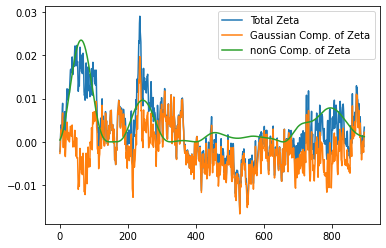

In [12]:
seed = 30
slicer.set_seed(seed)
factor = int(1e8)

fields = slicer.slice_1d()
d_1d, dg_1d, dng_1d, z_1d, zg_1d, zng_1d = fields
size = slicer.side_length

z_1d = factor * z_1d
zg_1d = factor * zg_1d
zng_1d = factor * zng_1d

#--------------------------------------------------#

### Plot 1D Zeta fields

plt.plot(z_1d, label='Total Zeta')
plt.plot(zg_1d, label='Gaussian Comp. of Zeta')
plt.plot(zng_1d, label='nonG Comp. of Zeta')

plt.legend()

## <u>Apply ICA to 1D strips from the 3D fields</u>
<b> For fully determined ICA separation.
<br>
Sklearn's implementation does not allow for underdetermined separation. </b>

### Setup

In [13]:
"""
source_noise    :   grf generated using gaussianfield [in Notebook Setup above]
source_nonG     :   returns n columns corresponding to n gaussian peaks that are shifted by xPeak/xc relative to 0 (and scaled by the size of the field)
source_comps    :   array of source component arrays
num_comps       :   num of different source signals/components, i.e. GRF & no. of peaks
num_samples     :   num of observations (has to be >= num_comps)
mix_matrix      :   mixing matrix generated randomly with entries over [0.5, 1)
mix_signal_pre  :   resulting mixed/observed signals (not prewhitened)
"""

source_noise = zg_1d # Gaussian random noise
source_nonG = zng_1d

source_comps = np.vstack([source_noise, source_nonG]) 
num_comps = source_comps.shape[0]
num_samples = num_comps

mix_matrix = (1+np.random.random((num_samples, num_comps)))/2.0 
print(mix_matrix.shape)
mix_signal_pre = np.dot(mix_matrix, source_comps) # mixed signals
print(mix_signal_pre.shape)

(2, 2)
(2, 896)


### Sklearn--Fully determined FastICA separation

#### Apply Sklearn's $\texttt{FastICA}$

In [14]:
# initialize FastICA with given params
# Logcosh is negentropy.

max_iter = int(9e2)
tol = 1e-8

transformer = FastICA(n_components=num_comps, algorithm='parallel', whiten='unit-variance', max_iter=max_iter, 
        tol=tol, fun='logcosh')

# run FastICA on observed (mixed) signals
sources = transformer.fit_transform(mix_signal_pre.T) # run FastICA on observed signals

In [15]:
source_max  = np.abs(source_comps).max()
ica_max     = np.abs(sources).max()
print(source_max)
print(ica_max)
sl          = sources * ( source_max / ica_max )
sl_max     = np.abs(sl).max()
print(sl_max)

0.02349908323484584
0.1442152570163036
0.02349908323484584


In [16]:
sl = -sl

In [17]:
sl[:,[1,0]] = sl[:, [0,1]]

#### Plot the following:
#### (1) Observed signals (random mixtures of source components),
#### (2) Source components,
#### (3) ICA separated signals.

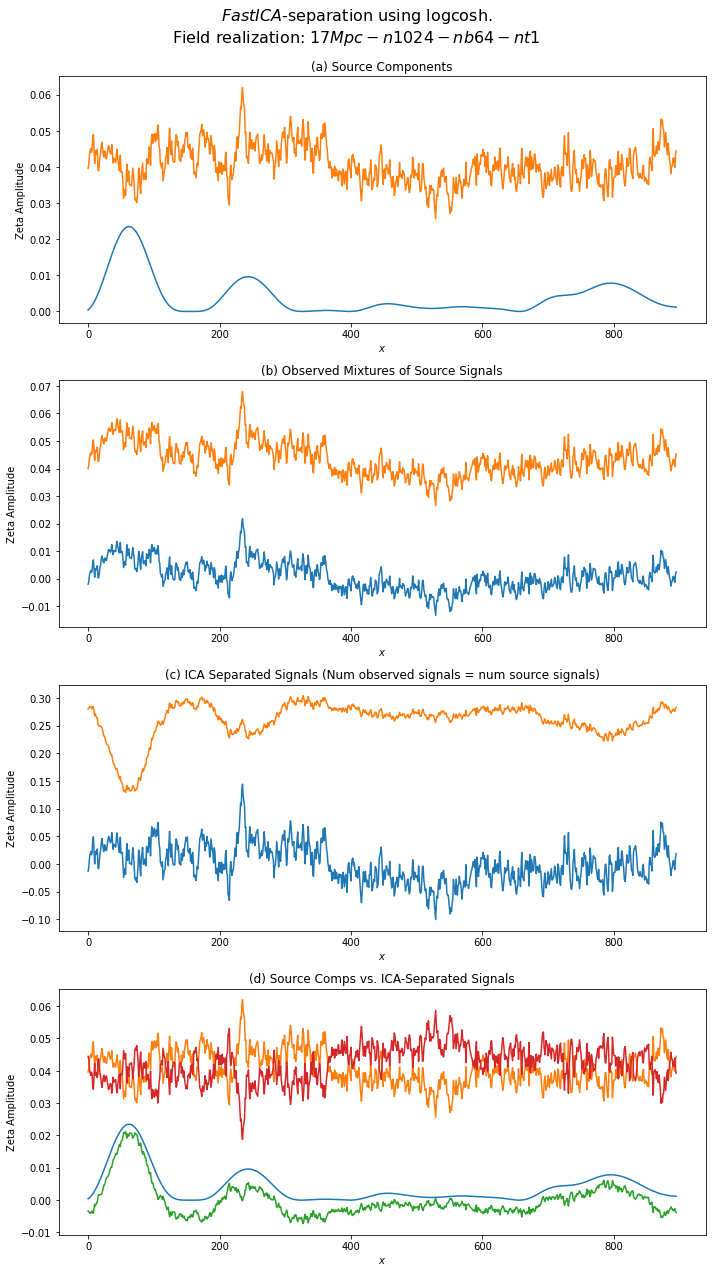

In [18]:
fig, ax = plt.subplots(4,1,figsize=(10,18))

scomps = np.flip(source_comps, axis=0)
offset = source_max*1.8
offset_ica = ica_max*1.8

# Plotting source components
ax[0].set_title("(a) Source Components")
for i in range(scomps.T.shape[-1]):
    ax[0].plot(scomps.T[:,i] + offset*i)
ax[0].set(xlabel=r'$x$', ylabel="Zeta Amplitude")
# ax[0].legend()


# Plotting observed signals (mixtures of source signals)
ax[1].set_title("(b) Observed Mixtures of Source Signals")
for i in range(mix_signal_pre.T.shape[-1]):
    ax[1].plot(mix_signal_pre.T[:,i] + offset*i)
ax[1].set(xlabel=r'$x$', ylabel="Zeta Amplitude")


# Plotting signals separated by ICA
ax[2].set_title("(c) ICA Separated Signals (Num observed signals = num source signals)")
for i in range(sources.shape[-1]):
    ax[2].plot(sources[:,i] + offset_ica*i) # Amplitudes are scaled arbitrarily because ICA doesn't recover amp
ax[2].set(xlabel=r'$x$', ylabel="Zeta Amplitude")


# Plotting comparison of source comps and ICA-separated signals
ax[3].set_title("(d) Source Comps vs. ICA-Separated Signals")
for i in range(scomps.T.shape[-1]):
    ax[3].plot(scomps.T[:,i] + offset*i)
for i in range(sl.shape[-1]):
    ax[3].plot(sl[:,i] + offset*i) # Amplitudes are scaled arbitrarily because ICA doesn't recover amp
ax[3].set(xlabel=r'$x$', ylabel="Zeta Amplitude")


fig.suptitle('$\it{FastICA}$-separation using logcosh.\nField realization: $\it{17Mpc-n1024-nb64-nt1}$\n', fontsize=16)
fig.tight_layout()

## <u>Apply Filtered ICA to 1D strips from the 3D fields</u>
<b> For fully determined ICA separation.
<br>
Sklearn's implementation does not allow for underdetermined separation. </b>

### Setup

In [86]:
# Top hat bands
def window(g, N, k_low, k_up):
    """
    
    """
    
    x = np.fft.rfft(g)
    # print(x[0:10])

    k = np.fft.rfftfreq(N) * N
    # print(k[0:10])

    # print(k[:N//2])

    k_low = np.ones(np.shape(x))*k_low
    k_up = np.ones(np.shape(x))*k_up

    x = np.where(np.logical_and(np.less_equal(k, k_up), np.greater(k, k_low)), x, 0)
    x_inv = np.fft.irfft(x)

    return x_inv

def window_hamm(g, N, k_low, k_high):
    """Apply Hamming window filter in k-space.
    
    """

    x = np.fft.rfft(g)

    k = np.fft.rfftfreq(N) * N

    k_range = k_high - k_low
    hamm = np.zeros(np.shape(x))
    hamm[k_low:k_high] = hamming(k_range, 0.5)

    k_low = np.ones(np.shape(x))*k_low
    k_high = np.ones(np.shape(x))*k_high

    x = np.where(np.logical_and(np.less_equal(k, k_high), np.greater_equal(k, k_low)), x*hamm, 0)
    print(x[:10])
    x_inv = np.fft.irfft(x)
    x_inv[:3] = 0
    x_inv[-3:] = 0
    
    return x_inv, hamm

def filter(g_field, ng_field, size, k_low, k_high):
    """
    
    """

    g_field = window(g_field, size, k_low, k_high)
    ng_field = window(ng_field, size, k_low, k_high)

    return [g_field, ng_field]


In [87]:

def ica_setup(source_noise, source_nonG):
    """
    source_noise    :   grf generated using gaussianfield [in Notebook Setup above]
    source_nonG     :   returns n columns corresponding to n gaussian peaks that are shifted by xPeak/xc relative to 0 (and scaled by the size of the field)

    source_comps    :   array of source component arrays
    num_comps       :   num of different source signals/components, i.e. GRF & no. of peaks
    num_samples     :   num of observations (has to be >= num_comps)
    mix_matrix      :   mixing matrix generated randomly with entries over [0.5, 1)
    mix_signal      :   resulting mixed/observed signals (not prewhitened)
    """

    # source_noise = zg_1d # Gaussian random noise
    # source_nonG = zng_1d

    source_comps = np.vstack([source_noise, source_nonG]) 
    num_comps = source_comps.shape[0]
    num_samples = num_comps

    mix_matrix = (1+np.random.random((num_samples, num_comps)))/2.0 
    mix_signal = np.dot(mix_matrix, source_comps) # mixed signals

    return 1e10*mix_signal, source_comps, num_comps

def ica_run(mix, num_comps, max_iter=1e4, tol=1e-15, 
        fun='logcosh', algo='parallel', white='unit-variance'):
    """Initialize FastICA with given params.

    Notes:
            Logcosh is negentropy.
    """
    
    transformer = FastICA(n_components=num_comps, algorithm=algo, whiten=white, max_iter=max_iter, tol=tol, fun=fun)

    # run FastICA on observed (mixed) signals
    sources = transformer.fit_transform(mix.T) # run FastICA on observed signals

    return sources

def ica_scale(source_comps, ica_sources):
    """
    
    """
    source_g_max  = np.abs(source_comps[0]).max()
    source_ng_max = np.abs(source_comps[1]).max()
    ica_0_max = np.abs(ica_sources[0]).max()
    ica_1_max = np.abs(ica_sources[1]).max()
    
    source_max  = np.abs(source_comps).max()
    ica_max     = np.abs(ica_sources).max()

    sl          = ica_sources * ( source_max / ica_max )
    sl_max     = np.abs(sl).max()

    return sl, source_max, ica_max

def ica_swap(ica_sources):
    """

    """

    ica_sources[:,[1,0]] = ica_sources[:, [0,1]]

    return ica_sources

def ica_flipsign(ica_sources):
    """
    
    """

    return -ica_sources

In [9]:

# #--------------------------------------------------#

# ### Plot 1D Zeta fields

# # plt.plot(z_1d, label='Total Zeta')
# # plt.plot(g, label='Gaussian Comp. of Zeta')
# plt.plot(zngf, label='nonG Comp. of Zeta')
# # plt.plot(W, label='Hamm filter')

# # plt.ylim([-1, 1])
# plt.legend()




### Apply Sklearn's $\texttt{FastICA}$

In [88]:
# x = np.fft.rfft(d_1d)

# k = np.fft.rfftfreq(size) * size
# print(np.abs(x[50:60]))
# # plt.plot(k, np.abs(x))
# plt.plot(zng_1d)

In [93]:
k_size = size//2 + 1
k_low = 0
k_high = k_size
# logtwo_size = int(np.log2(size))
# kc = np.logspace(0, logtwo_size-1, num=2, base=2.0)
kc = np.linspace(0, k_size, 10)
print(kc)
kc_size = kc.size


max_iter = int(9e2)
tol = 1e-8
ica_sources = np.empty(kc_size)

filtered = filter(zg_1d, zng_1d, size, int(kc[1]), int(kc[2]))
zgf, zngf = filtered[0], filtered[1]

mix_signal, source_comps, num_comps = ica_setup(zgf, zngf)
ica_src = ica_run(mix_signal, num_comps, max_iter, tol)
sl, source_max, ica_max = ica_scale(source_comps, ica_src)
# sl = ica_swap(sl)
scomps = np.flip(source_comps, axis=0)

[  0.          49.88888889  99.77777778 149.66666667 199.55555556
 249.44444444 299.33333333 349.22222222 399.11111111 449.        ]


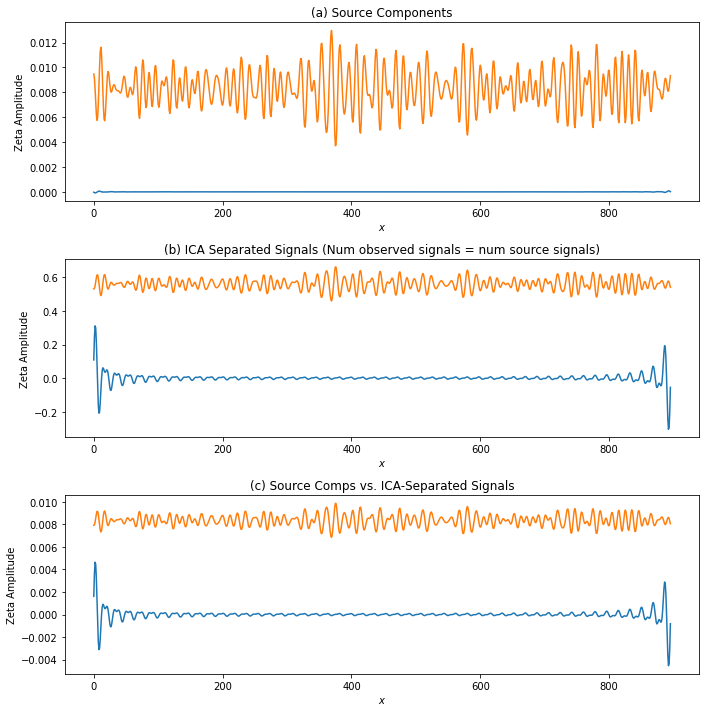

In [94]:
fig, ax = plt.subplots(3, 1, figsize=(10,10))
offset = source_max*1.8
offset_ica = ica_max*1.8

# Plotting source components
ax[0].set_title("(a) Source Components")
for i in range(scomps.T.shape[-1]):
    ax[0].plot(scomps.T[:,i] + offset*i)
ax[0].set(xlabel=r'$x$', ylabel="Zeta Amplitude")
# ax[0].legend()

# Plotting signals separated by ICA
ax[1].set_title("(b) ICA Separated Signals (Num observed signals = num source signals)")
for i in range(ica_src.shape[-1]):
    ax[1].plot(ica_src[:, i] + offset_ica*i) # Amplitudes are scaled arbitrarily because ICA doesn't recover amp
ax[1].set(xlabel=r'$x$', ylabel="Zeta Amplitude")

# Plotting comparison of source comps and ICA-separated signals
ax[2].set_title("(c) Source Comps vs. ICA-Separated Signals")
# for i in range(scomps.T.shape[-1]):
#     ax[1, 2].plot(scomps.T[:,i] + offset*i)
for i in range(sl.shape[-1]):
    ax[2].plot(sl[:,i] + offset*i) # Amplitudes are scaled arbitrarily because ICA doesn't recover amp
ax[2].set(xlabel=r'$x$', ylabel="Zeta Amplitude")

fig.tight_layout()

In [1]:
"""Filtering.

"""

k_size = size//2 + 1
k_low = 0
k_high = k_size
# logtwo_size = int(np.log2(size))
# kc = np.logspace(0, logtwo_size-1, num=2, base=2.0)
kc = np.linspace(0, k_size, 5)
kc_size = kc.size


max_iter = int(9e2)
tol = 1e-8
ica_sources = np.empty(kc_size)

mix_signal, source_comps, num_comps = ica_setup(zg_1d, zng_1d)
ica_src = ica_run(mix_signal, num_comps, max_iter, tol)
sl, source_max, ica_max = ica_scale(source_comps, ica_src)
scomps = np.flip(source_comps, axis=0)


plt.rcParams.update({'font.size': 5})
fig, ax = plt.subplots(11, 3, figsize=(9,25))
offset = source_max*1.8
offset_ica = ica_max*1.8

# Plotting source components
ax[0, 0].set_title("(a) Source Components")
for i in range(scomps.T.shape[-1]):
    ax[0, 0].plot(scomps.T[:,i] + offset*i)
ax[0, 0].set(xlabel=r'$x$', ylabel="Zeta Amplitude")
# ax[0].legend()

# Plotting signals separated by ICA
ax[0, 1].set_title("(c) ICA Separated Signals (Num observed signals = num source signals)")
for i in range(ica_src.shape[-1]):
    ax[0, 1].plot(ica_src[:, i] + offset_ica*i) # Amplitudes are scaled arbitrarily because ICA doesn't recover amp
ax[0, 1].set(xlabel=r'$x$', ylabel="Zeta Amplitude")

# Plotting comparison of source comps and ICA-separated signals
ax[0, 2].set_title("(d) Source Comps vs. ICA-Separated Signals")
# for i in range(scomps.T.shape[-1]):
#     ax[1, 2].plot(scomps.T[:,i] + offset*i)
for i in range(sl.shape[-1]):
    ax[0, 2].plot(sl[:,i] + offset*i) # Amplitudes are scaled arbitrarily because ICA doesn't recover amp
ax[0, 2].set(xlabel=r'$x$', ylabel="Zeta Amplitude")

for i in np.arange(0, kc_size):
    ax_count = i+1

    filtered = filter(zg_1d, zng_1d, size, int(kc[i]), int(kc[i+1]))
    zgf, zngf = filtered[0], filtered[1]
    
    mix_signal, source_comps, num_comps = ica_setup(zgf, zngf)
    ica_sources[i] = ica_run(mix_signal, num_comps, max_iter, tol)
    sl, source_max, ica_max = ica_scale(source_comps, ica_sources)
    scomps = np.flip(source_comps, axis=0)



    # Plotting source components
    ax[ax_count, 0].set_title("(a) Source Components")
    for j in range(scomps.T.shape[-1]):
        ax[ax_count, 0].plot(scomps.T[:,j] + offset*j)
    ax[ax_count, 0].set(xlabel=r'$x$', ylabel="Zeta Amplitude")
    # ax[0].legend()

    # Plotting signals separated by ICA
    ax[ax_count, 2].set_title("(c) ICA Separated Signals (Num observed signals = num source signals)")
    for j in range(ica_sources[i].shape[-1]):
        ax[ax_count, 2].plot(ica_sources[i, :, j] + offset_ica*j) # Amplitudes are scaled arbitrarily because ICA doesn't recover amp
    ax[ax_count, 2].set(xlabel=r'$x$', ylabel="Zeta Amplitude")

    # Plotting comparison of source comps and ICA-separated signals
    ax[ax_count, 3].set_title("(d) Source Comps vs. ICA-Separated Signals")
    # for j in range(scomps.T.shape[-1]):
    #     ax[i, 3].plot(scomps.T[:,j] + offset*j)
    for j in range(sl.shape[-1]):
        ax[ax_count, 3].plot(sl[:,j] + offset*j) # Amplitudes are scaled arbitrarily because ICA doesn't recover amp
    ax[ax_count, 3].set(xlabel=r'$x$', ylabel="Zeta Amplitude")

fig.tight_layout()
fig.suptitle('$\it{FastICA}$-separation using logcosh.\nField realization: $\it{17Mpc-n1024-nb64-nt1}$\n', fontsize=16)

NameError: name 'size' is not defined

In [ ]:
# filtered = filter(zg_1d, zng_1d, size, int(kc[0]), int(kc[1]))
# zgf, zngf, hamm = filtered[0], filtered[1], filtered[2]
# mix_signal, source_comps, num_comps = ica_setup(zgf, zngf)
# ica_sources = ica_run(mix_signal, num_comps, max_iter, tol)
# sl, source_max, ica_max = ica_scale(source_comps, ica_sources)

#### Plot the following:
#### (1) Observed signals (random mixtures of source components),
#### (2) Source components,
#### (3) ICA separated signals.

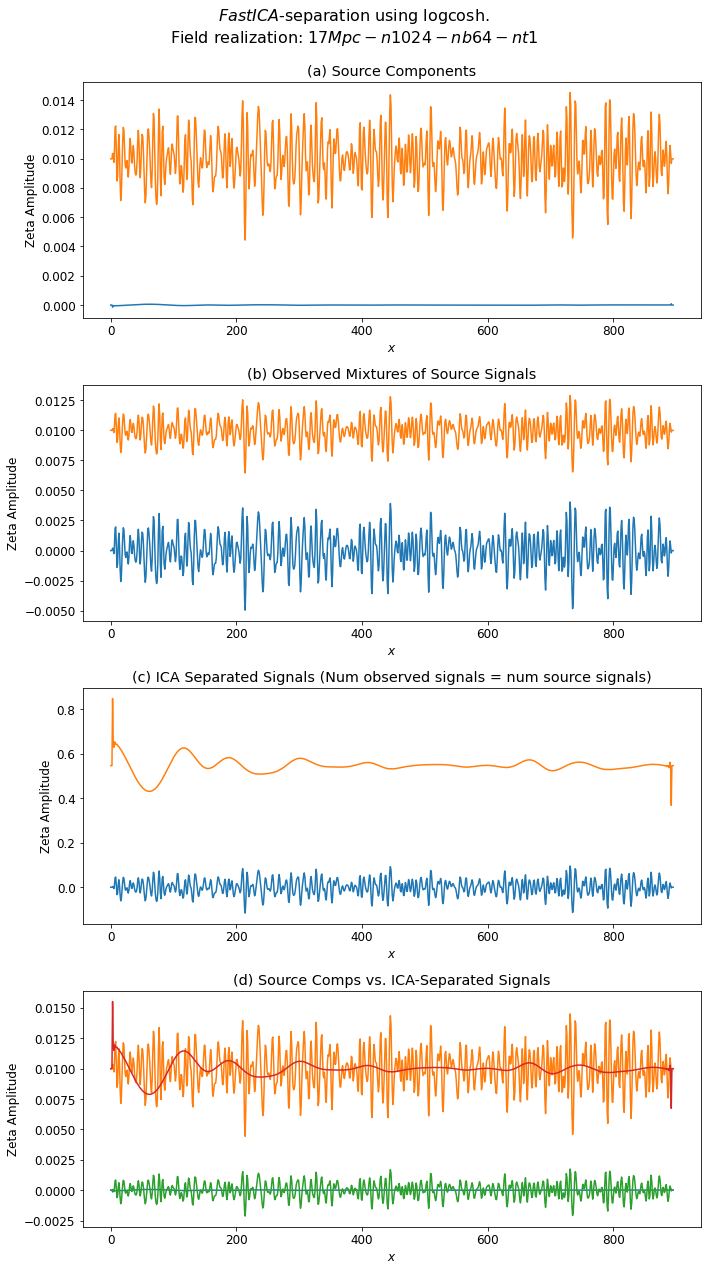

In [153]:


# Plotting source components
ax[0].set_title("(a) Source Components")
for i in range(scomps.T.shape[-1]):
    ax[0].plot(scomps.T[:,i] + offset*i)
ax[0].set(xlabel=r'$x$', ylabel="Zeta Amplitude")
# ax[0].legend()


# Plotting observed signals (mixtures of source signals)
ax[1].set_title("(b) Observed Mixtures of Source Signals")
for i in range(mix_signal.T.shape[-1]):
    ax[1].plot(mix_signal.T[:,i] + offset*i)
ax[1].set(xlabel=r'$x$', ylabel="Zeta Amplitude")


# Plotting signals separated by ICA
ax[2].set_title("(c) ICA Separated Signals (Num observed signals = num source signals)")
for i in range(ica_sources.shape[-1]):
    ax[2].plot(ica_sources[:,i] + offset_ica*i) # Amplitudes are scaled arbitrarily because ICA doesn't recover amp
ax[2].set(xlabel=r'$x$', ylabel="Zeta Amplitude")


# Plotting comparison of source comps and ICA-separated signals
ax[3].set_title("(d) Source Comps vs. ICA-Separated Signals")
for i in range(scomps.T.shape[-1]):
    ax[3].plot(scomps.T[:,i] + offset*i)
for i in range(sl.shape[-1]):
    ax[3].plot(sl[:,i] + offset*i) # Amplitudes are scaled arbitrarily because ICA doesn't recover amp
ax[3].set(xlabel=r'$x$', ylabel="Zeta Amplitude")


fig.suptitle('$\it{FastICA}$-separation using logcosh.\nField realization: $\it{17Mpc-n1024-nb64-nt1}$\n', fontsize=16)
fig.tight_layout()

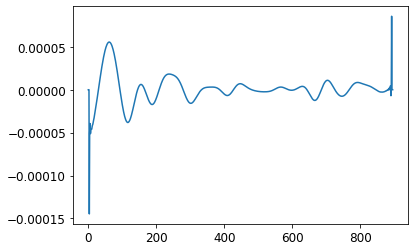

In [154]:
plt.plot(scomps.T[:,0])


### TODO: Rank-order the extracted signals (by a nonG measure)
e.g. using kurtosis

In [ ]:
# # Rank-order by a nonGaussianity measure (kurtosis for simplicity)
# nt = 100; a = np.empty((nt,s.shape[0],s.shape[1])) 
# for i in range(nt):
#     a[i] = ica.extract_peaks_nn(num_samples=num_samples, num_components=num_comps, noise=noise, aPeak=aPeak, xPeak=xPeak, wPeak=wPeak, ns=size_field)[-1]
# kur = ica.kurtosis(a)

# print(kur.shape)
# fig, a = plt.subplots()
# fig.set_size_inches(15, 15)
# for i in range(kur.shape[-1]):
#     a.plot(kur[:,i]+25.*i)